## *UF Audio Engineering Society

Jackson Cornell, Justin Broce, Eric Barkuloo


# **Creating an instrument classifier**



In [1]:
#@title Loading libraries
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import IPython
import soundfile as sf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input



In [2]:
#@title Loading Data
!git clone https://github.com/aesuf/orchestral_samples;
!git clone https://github.com/justinbroce/x_data;

Cloning into 'orchestral_samples'...
remote: Enumerating objects: 11633, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 11633 (delta 1), reused 1 (delta 1), pack-reused 11631
Receiving objects: 100% (11633/11633), 1.28 GiB | 31.32 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Checking out files: 100% (11319/11319), done.
Cloning into 'x_data'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 1), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [3]:
#@title helper functions

#We take the first n seconds of the audio. If the audio is too short, we append zeros.

def trim_sample(y,sr,seconds):
  return librosa.util.fix_length(y,size=int((sr*seconds)))


def get_filenames():
  #files is a list of the names of all of our downloaded files
  files = os.listdir('orchestral_samples/data')
  """
  files[0] might look like 'bass-clarinet_Fs3_15_pianissimo_normal.wav'
  so we append 'orchestral_samples/data' to the start of every file
  so we can load it easier
  """
  return list(
      map(
      lambda file: 'orchestral_samples/data/' + file , files)
  )
  #scaling spectrograms as normalized images:
  #hopefully this will fix things, idk
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

##loading the names of all of our files from our downloaded data
Our dataset contains 11318 samples, of 16 different instrument types.
Each sample will have a note name and a technique of playing, in the filename.

In [4]:
files = get_filenames()
print('number of samples: ', len(files))



number of samples:  11318


We can visualize our samples and take a listen to a couple different sounds.

example file name:  orchestral_samples/data/clarinet_B4_05_fortissimo_normal.wav


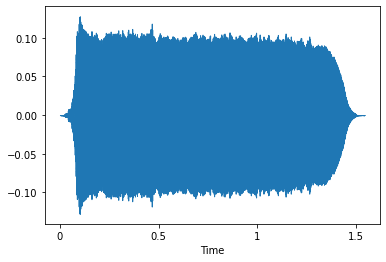

In [5]:
i = np.random.randint(0,len(files)-1)
librosa.display.waveshow(*librosa.load(files[i]))

print('example file name: ', files[i])

In [6]:

IPython.display.Audio(files[i]) 

# Mel Spectrograms.
* Our plot was a time domain representation of our audio. Basically loudness over time. This might be useful for finding features such as how loud a sound is, or when a note starts, but it doesn't really give us much information about the frequency domain. We are trying to see if we can predict what instruments are which based on recordings; something that we will need a different respresentation to find valuable information.


* Mel spectrograms are common tranformations used in speech and audio processing, that allow more meaning than just the time domain representation that we have seen. Basically a mel spectrogram is a Short Time Fourier transform, that has been log scaled so that the difference between frequencies are more in tune with the way that humans percieve sound. An a4 is 440hz and an a5 is 880 hz and an a6 is 1760.00, but we percieve the difference between a4 and a5, to be the same as the different between a5 and a6, despite the deltas being 440, vs 880. That is why we want a mel scale version. 

* They explain it better here: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0

Function to extract mel melspectrogram from a sample

In [7]:
#@title extract mel
def extract_mel(y,sr):
  y = trim_sample(y,sr,1.5) #we are looking at the first 15 seconds of each sample
  hop_length = 512
  n_fft = 2048
  n_mfcc=128
  #we normalize value between 0 and 1
  return scale_minmax(librosa.feature.melspectrogram(y, n_fft=n_fft,hop_length=hop_length));
    

# The setup
What we will be doing for this project is taking the first 1.5 seconds of audio, and converting it to the mel spectrogram. We will do this for every sample, and these spectrograms will be our x data. Here is an example of us extracting a mel spectrogram

In [8]:
#code to load an audio file
# y is a numpy array of the amplitudes, and sr is the sample rate
y,sr = librosa.load(files[310])

In [9]:
print(files[310])

orchestral_samples/data/double-bass_Ds3_1_fortissimo_arco-normal.wav


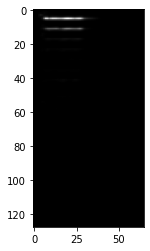

In [10]:
#plotting the spectrogram as an image: 
plt.imshow(extract_mel(y,sr),cmap='gray')

**We can also convert mel spectrograms back into audio**
which is implemented by converting the mel spectrogram back to the STFT, and then to audio using a fancy algorithm [Griffin-Lim
](]https://paperswithcode.com/method/griffin-lim-algorithm)

*I think that it would be interesting to try to generate mel spectrograms using a GAN, and then to convert the generated spectrogram to audio using these functions.*

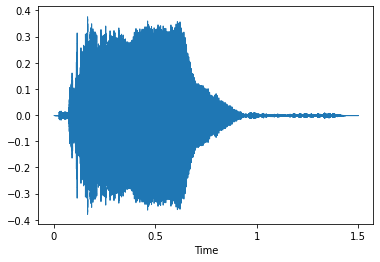

In [11]:
#@title Original Audio
original = trim_sample(y,sr,1.5)
librosa.display.waveshow(original)

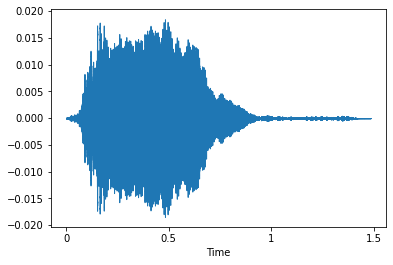

In [12]:
#@title Reconstructed Audio
reconstructed = librosa.feature.inverse.mel_to_audio(extract_mel(y,sr),22050,n_fft = 2048,hop_length = 512)
librosa.display.waveshow(reconstructed)


In [13]:
#@title Original
sf.write('orig.wav', original,22050)
IPython.display.Audio('orig.wav')

In [14]:
#@title Reconstructed
sf.write('recon.wav', reconstructed,22050)
IPython.display.Audio('recon.wav')

Creating a feature array of the right dimension, at with entry populated with zeroes

In [15]:
y,sr= librosa.load(files[1])
y = trim_sample(y,sr,1.5)
mel_dims = extract_mel(y,sr).shape
features = np.zeros((len(files),mel_dims[0],mel_dims[1]))
print('\ndimensions of our features array:', features.shape)


dimensions of our features array: (11318, 128, 65)


We populate each ith element of features with a
mel spectrogram of each file.

*Warning: this is extremly slow and takes around 15 minutes*


Maybe take a coffee break in the meanwhile

*Also, I suggest using a high ram enviroment(which can selected in google colab), because we are using a tooooooon of memory with huge matrices!*

In [16]:

i = 0
for file in files:
  features[i] = extract_mel(*librosa.load(file,duration=1.5))
  i = i+1
  if i%1000==0:
    print("sample: ", i)
  


sample:  1000
sample:  2000
sample:  3000
sample:  4000
sample:  5000
sample:  6000
sample:  7000
sample:  8000
sample:  9000
sample:  10000
sample:  11000


Now we have features array of dim `(11318, 128, 65)`
where each `features[i]` corresponds to the mel spectrogram of the file: `files[i]`

## **Getting the Y values, and labels**


In [17]:
#@title helper functions
def get_instruments():
  instruments = {
  "bass-clarinet": 0,
  "contrabassoon": 1,
  "cello": 2,
  "clarinet": 3,
  "bassoon": 4,
  "double-bass": 5,
  "french-horn": 6,
  "guitar": 7,
  "mandolin": 8,
  "oboe": 9,
  "saxophone": 10,
  "trombone": 11,
  "trumpet": 12,
  "tuba": 13,
  "viola": 14,
  "violin": 15,
  
   #instruments is a python dictionary
  #read more at https://www.w3schools.com/python/python_dictionaries.asp
  #similiar to a hashmap, or c++'s ordered_map
}
  return instruments


"""
This function will return the instrument class value given the filename ie
get_y_val('cello_Gs2_05_pianissimo_arco-normal.wav')
  returns 2

And get_y_val(double-bass_D2_1_pianissimo_arco-normal.wav)
returns 5

"""
def get_y_value(file):
  instruments = get_instruments()
  for instrument in instruments:
    #string.find(foo) returns the first occurence of foo,
    # and -1 if foo is not in the string.
    if file.find(instrument)!=-1:
      return instruments[instrument]
  return "NULL"

def get_y_values():
  #loading the names of the files in /data to a list
  files = os.listdir('orchestral_samples/data')
  """
  map(f,iterable) will apply functiion f to each element in iterable container.
  In this case we are applying the function get_y_value, 
  to every element in files. List will turn a map object into a list,
   and then we can turn the list into a numpy array
  """
  return np.array(
      list(
          map(get_y_value,files)
          )
      )
  
"""
 generates numpy array that maps indices to instruments
 ie get_labels()[3] returns 'clarinet'
"""
def get_labels():
  inv_map = {v: k for k, v in get_instruments().items()}
  return np.array(list(inv_map.items()))[:,[1]]


In [18]:
y_data = get_y_values()
labels = get_labels()

# **Test Train Split etc:** 

*finally we will have data in a format that can be fed into models*


In [19]:
#@title importing more stuff
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import to_categorical # it's red but okay

##Performing test/train split:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    features, y_data, test_size=0.33, random_state=42)

X train and test are the spectrograms

Y train and test are the what instruments the samples are

In [21]:
print(f"""
X_train dims: {X_train.shape}
X_test dims: {X_test.shape}
Y_train dims: {y_train.shape}
Y_test dims: {y_test.shape}
"""
)


X_train dims: (7583, 128, 65)
X_test dims: (3735, 128, 65)
Y_train dims: (7583,)
Y_test dims: (3735,)



In [22]:
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

If you want to know what instrument a sample is by y_value:

In [23]:
print(y_train_cat.shape)
print(labels[np.argmax(y_train_cat)])
print(y_train.shape)
print(labels[y_train[0]])

(7583, 16)
['double-bass']
(7583,)
['double-bass']


# Creating image with 3 channels
### you might want to enable high ram usage, or this might crash. It might crash regardless.

In [ ]:
#@title Creating spectrogram images with 3 channels
#@markdown if running you might want to enable high ram usage, or this might crash. It might crash regardless tho
cnn_x_train = np.zeros((7583,128, 65,3))
cnn_x_test  = np.zeros((3735, 128, 65,3))
cnn_x_train[:,:,:,0] = X_train
cnn_x_train[:,:,:,1] = X_train
cnn_x_train[:,:,:,2] = X_train
cnn_x_test[:,:,:,0] = X_test
cnn_x_test[:,:,:,1] = X_test
cnn_x_test[:,:,:,2] = X_test

In [ ]:
print(cnn_x_test.shape,cnn_x_train.shape)

(3735, 128, 65, 3) (7583, 128, 65, 3)


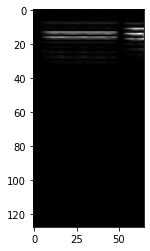

In [ ]:
plt.imshow(cnn_x_test[200])


#CNN

In [140]:
model = keras.models.Sequential()

model.add(keras.Input(shape=(128, 65))) 

model.add(keras.layers.Conv1D(filters = 64, kernel_size = (3), 
                              activation = 'ReLU', use_bias = False, 
                              padding = 'same',
                              strides = 1
                              ))
model.add(keras.layers.Conv1D(filters = 64, kernel_size = (3), 
                              activation = 'ReLU', use_bias = False, 
                              padding = 'same',
                              strides = 1
                              ))
model.add(keras.layers.MaxPool1D(pool_size = (3)))
model.add(layers.Dropout(0.25, name="top_dropout"))
model.add(keras.layers.Conv1D(filters = 64, kernel_size = (3), 
                              activation = 'ReLU', use_bias = False, 
                             padding = 'same'))
model.add(keras.layers.Conv1D(filters = 64, kernel_size = (3), 
                              activation = 'ReLU', use_bias = False, 
                             padding = 'same'))

model.add(keras.layers.MaxPool1D(pool_size = (3)))
model.add(layers.Dropout(0.25, name="top_dropout2"))
model.add(keras.layers.Conv1D(filters = 64, kernel_size = (3), 
                              activation = 'ReLU', use_bias = False, 
                             padding = 'same'))
model.add(keras.layers.Conv1D(filters = 64, kernel_size = (3), 
                              activation = 'ReLU', use_bias = False, 
                             padding = 'same'))
model.add(keras.layers.MaxPool1D(pool_size = (2)))



model.add(keras.layers.Flatten())
model.add(layers.Dropout(0.25, name="top_dropout3"))
model.add(keras.layers.Dense(16, activation='softmax', use_bias=False))

model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics=['accuracy'])

In [141]:
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_119 (Conv1D)         (None, 128, 64)           12480     
                                                                 
 conv1d_120 (Conv1D)         (None, 128, 64)           12288     
                                                                 
 max_pooling1d_100 (MaxPooli  (None, 42, 64)           0         
 ng1D)                                                           
                                                                 
 top_dropout (Dropout)       (None, 42, 64)            0         
                                                                 
 conv1d_121 (Conv1D)         (None, 42, 64)            12288     
                                                                 
 conv1d_122 (Conv1D)         (None, 42, 64)            12288     
                                                     

In [142]:
h = model.fit(X_train, y_train_cat, epochs = 16, validation_data = (X_test, y_test_cat))

Epoch 1/16
237/237 [==============================] - 4s 13ms/step - loss: 2.0489 - accuracy: 0.3160 - val_loss: 1.5331 - val_accuracy: 0.4988
Epoch 2/16
237/237 [==============================] - 3s 13ms/step - loss: 1.4174 - accuracy: 0.5299 - val_loss: 1.1600 - val_accuracy: 0.6182
Epoch 3/16
237/237 [==============================] - 3s 12ms/step - loss: 1.1548 - accuracy: 0.6189 - val_loss: 0.9735 - val_accuracy: 0.6985
Epoch 4/16
237/237 [==============================] - 3s 12ms/step - loss: 0.9967 - accuracy: 0.6736 - val_loss: 0.8792 - val_accuracy: 0.7256
Epoch 5/16
237/237 [==============================] - 3s 12ms/step - loss: 0.9066 - accuracy: 0.7013 - val_loss: 0.7662 - val_accuracy: 0.7566
Epoch 6/16
237/237 [==============================] - 3s 11ms/step - loss: 0.8186 - accuracy: 0.7244 - val_loss: 0.7324 - val_accuracy: 0.7652
Epoch 7/16
237/237 [==============================] - 3s 12ms/step - loss: 0.7610 - accuracy: 0.7472 - val_loss: 0.6669 - val_accuracy: 0.7842

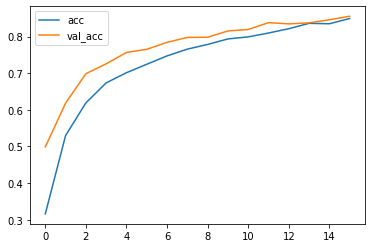

In [143]:
plt.plot(h.history['accuracy'], label = 'acc')
plt.plot(h.history['val_accuracy'], label = 'val_acc')
plt.legend()